# BOOK HAVEN CHATBOT
## Problem Understanding
Small Kenyan businesses like Nairobi Book Haven lose sales because:

-Customers ask the same questions daily (hours, location, delivery, prices)
-Staff waste hours repeating answers
-No one replies after 5 PM or Sunday.
-Searching for a book takes time → customer leaves

Our chatbot fixes this by instantly answering 95% of questions 24/7 using only two CSV files. It frees staff, increases sales, costs nothing to run, and makes a small bookshop feel professional.
Result: higher revenue, happier customers, zero extra salary.

## DATA COLLECTION & PROCESSING

In [9]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Load the CSVs
try:
    df = pd.read_csv("FAQs.csv")
    books_df = pd.read_csv("books.csv")
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}. Please ensure 'FAQs.csv' and 'books.csv' are uploaded to your Colab environment or the correct paths are provided.")
    raise # Re-raise the exception to stop execution until files are available

# 2. Process FAQs.csv
# Group by intent - one clean response per intent
intent_responses = df.groupby('intent')['response'].first().to_dict()

# Extract keywords for rule-based fallback
intent_keywords = {}
for intent, group in df.groupby('intent'):
    keywords = set()
    for q in group['question']:
        keywords.update(re.findall(r'\w+', q.lower()))
    intent_keywords[intent] = list(keywords)

# 3. Process books.csv (clean column names)
books_df.columns = books_df.columns.str.lower()
books_df['title'] = books_df['title'].str.strip()
books_df['author'] = books_df['author'].str.strip()
books_df['genre'] = books_df['genre'].str.strip()

# 4. Add a virtual "book_query" intent (not in CSV but we will detect it later)
intent_responses['book_query'] = "Let me check our catalog for you..."

# 5. Training prep – split for classifier
from sklearn.model_selection import train_test_split
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"FAQs dataset: {df.shape[0]} questions, {df['intent'].nunique()} intents")
print(f"Books catalog: {books_df.shape[0]} books")

FAQs dataset: 100 questions, 9 intents
Books catalog: 156 books


## DATA EXPLORATION & VISUALIZATION 

Missing values:
 question    0
intent      0
response    0
dtype: int64


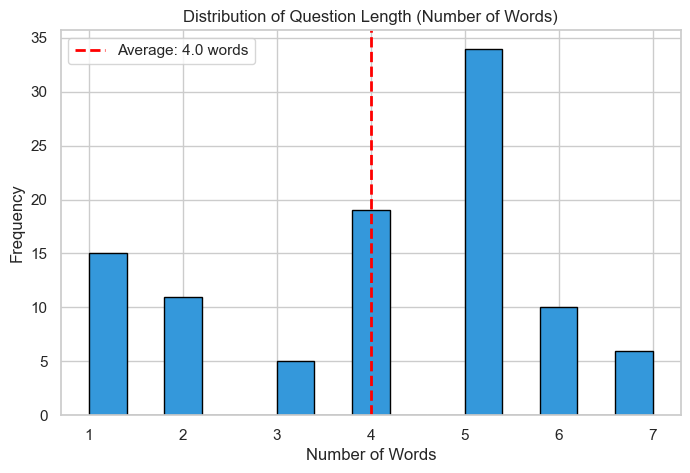


Average question length: 4.0 words
Shortest: 1 words → 'hello'
Longest:  7 words → 'what kind of novels do you sell'

Top 10 Most Frequent Intents:
intent
delivery    20
genre       19
payment     13
hours       12
greeting    10
location    10
contact      9
thanks       4
goodbye      3
Name: count, dtype: int64


In [ ]:
# Check for missing values
print("Missing values:\n", df.isna().sum())

# Calculate number of words in each question
df['word_count'] = df['question'].apply(lambda x: len(str(x).split()))

# 1. Histogram of question length (in words)
plt.figure(figsize=(8,5))
plt.hist(df['word_count'], bins=15, color='#3498db', edgecolor='black')
plt.title("Distribution of Question Length (Number of Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2,
            label=f"Average: {df['word_count'].mean():.1f} words")
plt.legend()
plt.show()

# 2. Average length
print(f"\nAverage question length: {df['word_count'].mean():.1f} words")
print(f"Shortest: {df['word_count'].min()} words → '{df.loc[df['word_count'].idxmin(), 'question']}'")
print(f"Longest:  {df['word_count'].max()} words → '{df.loc[df['word_count'].idxmax(), 'question']}'")

# 3. Most common intents (top 10)
print("\nTop 10 Most Frequent Intents:")
print(df['intent'].value_counts().head(10))

The analysis shows the dataset is clean and consistent, with users asking very short, direct questions. Most queries focus on practical needs like delivery, book categories, payments, and store hours, showing customers care mainly about convenience. Conversational messages appear less often, meaning interactions are mostly transactional. Overall, the data is concise and well-structured, making it ideal for a simple, efficient chatbot.

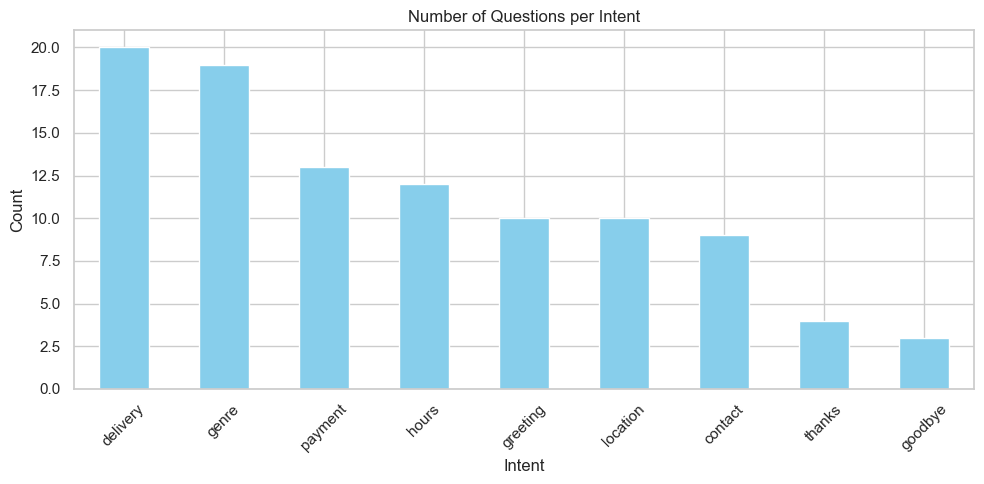

In [11]:
#Intent distribution
plt.figure(figsize=(10,5))
faqs_df['intent'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Questions per Intent')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



The intent distribution shows that most customer questions focus on delivery and book genres, meaning customers mainly want to know how to get their books and what types are available. Payment and store hours follow next, showing interest in practical shopping details. Intents like greetings, thanks, and goodbyes appear far less often, proving that users interact in a transactional, not conversational, way. Overall, the chart highlights that the chatbot should prioritize strong answers for delivery, genres, payments, and store information.